In [576]:
import cirq
import random
import numpy as np
from bloqade.cirq_utils import load_circuit

def clifford_mixer(q: cirq.Qid) -> list[cirq.Operation]:
    # fixed single-qubit Clifford "mixer"
    return random.choice([[cirq.H(q)], [cirq.S(q)]])   # both Clifford

def t_layer(q: cirq.Qid) -> list[cirq.Operation]:
    return [cirq.T(q)]             # non-Clifford

def make_1q_circuit(t_layers: int) -> cirq.Circuit:
    q = cirq.LineQubit(0)
    ops = []

    ops += clifford_mixer(q)
    for _ in range(t_layers):
        ops += clifford_mixer(q)
        ops += t_layer(q)

    return cirq.Circuit(ops), q

# example
c = make_1q_circuit(t_layers=1)



In [577]:
# --- 6 single-qubit Clifford (Pauli) eigenstates: ±X, ±Y, ±Z ---
def clifford_eigenstates_6():
    z_plus  = np.array([1, 0], dtype=complex)                       # |0>
    z_minus = np.array([0, 1], dtype=complex)                       # |1>
    x_plus  = (1/np.sqrt(2)) * np.array([1, 1], dtype=complex)      # |+>
    x_minus = (1/np.sqrt(2)) * np.array([1,-1], dtype=complex)      # |->
    y_plus  = (1/np.sqrt(2)) * np.array([1, 1j], dtype=complex)     # |i>
    y_minus = (1/np.sqrt(2)) * np.array([1,-1j], dtype=complex)     # |-i>
    return {
        "Z+": z_plus,  "Z-": z_minus,
        "X+": x_plus,  "X-": x_minus,
        "Y+": y_plus,  "Y-": y_minus,
    }

def fidelity(psi: np.ndarray, phi: np.ndarray) -> float:
    try:
        return float(np.arccos(np.abs(np.vdot(phi, psi))))
    except:
        return float(0)

# --- simulate statevectors and compute fidelities ---
sim = cirq.Simulator()
refs = clifford_eigenstates_6()

def analyze(t_layers_list):
    kernels = []
    min_fids = []
    print("t_layers | " + "  ".join([f"{k:>6s}" for k in refs.keys()]))
    print("-" * (9 + 2 + 8 * len(refs)))
    for tL in t_layers_list:
        circuit, q = make_1q_circuit(tL)
        sub_kernel = load_circuit(
            circuit,
            kernel_name="sub_kernel",
            register_as_argument=True,
        )
        kernels.append(sub_kernel)
        psi = sim.simulate(circuit, qubit_order=[q]).final_state_vector
        fids = [fidelity(psi, refs[name]) for name in refs.keys()]
        min_fids.append(min(fids))
    return kernels,min_fids

# example sweep
sub_kernels,dists = analyze(range(0, 20))
print(dists)

t_layers |     Z+      Z-      X+      X-      Y+      Y-
-----------------------------------------------------------
[0.00018500957359127246, 0.3926990006059754, 0.78539809621802, 0.3926990006059754, 0.3926989769759101, 0.27401414118168693, 0.00018500957299118296, 0.3926992041089514, 0.2740142910660205, 0.14697519788269633, 0.29395021737383503, 0.392698970803644, 0.1469755189428273, 0.3926990304083021, 0.19252856859624415, 0.27401411527283476, 0.00034427059201577704, 0.2740142151371925, 0.39269917430663726, 0.33780142206884034]


/var/folders/n_/1wl7_2l52y3g1_82hvk9hw3h0000gn/T/ipykernel_11266/2022323902.py:17: RuntimeWarning: invalid value encountered in arccos
  return float(np.arccos(np.abs(np.vdot(phi, psi))))


In [578]:
##########################
## implement a3 in squin ##
##########################
from bloqade import squin
from bloqade.types import Qubit
from kirin.dialects import ilist
from bloqade.cirq_utils import load_circuit
from bloqade.cirq_utils.emit import emit_circuit
from bloqade.cirq_utils import noise
import bloqade.stim
import bloqade.tsim
import numpy as np
from math import pi
from typing import Literal


@squin.kernel
def magicstateprep(qubits,ind):
    squin.h(qubits[ind])
    squin.t(qubits[ind])


def mapping_f(n):
    dicti = {0:1, 1:3, 2:7, 3:6, 4:2, 5:5, 6:4}


'''@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    squin.reset(q[0:6])
    #squin.h(q[6])
    for i in range(6):
        squin.ry(-pi / 2, q[i])
    squin.cz(q[1], q[2])
    squin.cz(q[3], q[4])
    squin.cz(q[5], q[6])
    squin.ry(pi / 2, q[6])
    squin.cz(q[0], q[3])
    squin.cz(q[2], q[5])
    squin.cz(q[4], q[6])
    for i in range(2, 7):
        squin.ry(pi / 2, q[i])
    for i in range(0, 5, 2):
        squin.cz(q[i], q[i + 1])
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[2])
    squin.ry(pi / 2, q[4])

    squin.cx(q[0],q[2])
    squin.cx(q[2],q[0])
    squin.cx(q[0],q[2])

    squin.cx(q[2],q[6])
    squin.cx(q[6],q[2])
    squin.cx(q[2],q[6])

    squin.cx(q[3],q[6])
    squin.cx(q[6],q[3])
    squin.cx(q[3],q[6])

    squin.z(q[3])
    squin.x(q[6])'''

num_magic = 19

@squin.kernel
def injection(q: ilist.IList[Qubit, Literal[7]]):
    """Apply magic-state injection to the 7-qubit register `q` (allocated by caller)."""
    #squin.reset(q[0:2])
    #squin.reset(q[3:7])
    #magicstateprep(q,2)
    sub_kernels[num_magic]([q[2]])
    
    # ry(-pi/2) on old 0..5  ->  new [3,1,0,6,4,5]
    for j in (3, 1, 0, 6, 4, 5):
        squin.ry(-pi / 2, q[j])

    # cz(1,2), cz(3,4), cz(5,6) -> cz(1,0), cz(6,4), cz(5,2)
    squin.cz(q[1], q[0])
    squin.cz(q[6], q[4])
    squin.cz(q[5], q[2])

    # ry on old 6 -> new 2
    squin.ry(pi / 2, q[2])

    # cz(0,3), cz(2,5), cz(4,6) -> cz(3,6), cz(0,5), cz(4,2)
    squin.cz(q[3], q[6])
    squin.cz(q[0], q[5])
    squin.cz(q[4], q[2])

    # ry on old 2..6 -> new [0,6,4,5,2]
    for j in (0, 6, 4, 5, 2):
        squin.ry(pi / 2, q[j])

    # cz(0,1), cz(2,3), cz(4,5) -> cz(3,1), cz(0,6), cz(4,5)
    squin.cz(q[3], q[1])
    squin.cz(q[0], q[6])
    squin.cz(q[4], q[5])

    # final single-qubit ry: old 1 -> 1, old 2 -> 0, old 4 -> 4
    squin.ry(pi / 2, q[1])
    squin.ry(pi / 2, q[0])
    squin.ry(pi / 2, q[4])
    squin.z(q[3])
    squin.x(q[0])
    squin.x(q[1])
    squin.x(q[3])



@squin.kernel
def main():
    q = squin.qalloc(7)
    injection(q)
    
circ = emit_circuit(main)
circ_load = load_circuit(circ)
circ_stim = bloqade.tsim.Circuit(circ_load)
graph = circ_stim.diagram(type="timeline-svg")


# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding Functions
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode |0⟩^7 → |0⟩_L on the 7-qubit register q (Steane [[7,1,3]])."""
    squin.h(q[0])
    squin.h(q[1])
    squin.h(q[3])
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encode 7 qubits as |+⟩_L: first |0⟩_L then transversal H."""
    steane_encode_zero_on(q)
    for i in range(7):
        squin.h(q[i])


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """A3 circuit implementation in squin."""
    q = squin.qalloc(21)
    
    #steane_encode_zero_on(q[0:7])
    injection(q)
    # Qubits 0-6: logical data
    # Qubits 8-14 + 15-21: ancilla block

    # Prepare ancilla as |+⟩_L for first half (X-stabilizer syndrome)
    steane_encode_plus_on(q[7:14])

    # CNOTs: data → ancilla (X-syndrome extraction)
    for i in range(7):
        squin.cx(q[i], q[i+7])

    # Reset ancilla qubits 8-14
    #for i in range(8, 15):
    #    squin.reset(q[i])
    
    # Prepare ancilla as |0⟩_L for second half (Z-stabilizer syndrome)
    steane_encode_zero_on(q[14:21])

    # CNOTs: ancilla → data (Z-syndrome extraction)
    for i in range(7):
        squin.cx(q[i+14], q[i])

    # Transversal H on ancilla
    for i in range(7):
        squin.h(q[i+14])
    
    # Measure ancilla qubits 7-21 (Syndrome bits)
    for i in range(7, 21):
        squin.measure(q[i])

graph

In [579]:

synd_dict = {1:[1,3,5,7],2:[4,5,6,7],3:[2,3,6,7]}

In [580]:
def to_parity(li):
    li_new = [-2*el+1 for el in li]
    return li_new

li = [False, True, False]

In [581]:
def find_syndrome(li, idx):
    li = to_parity(li)
    mult = 1
    for ind in idx:
        mult *= li[ind-1]
    return True if mult == 1 else False


In [582]:
def findZSyndrome(sample,idx):
    sample_z = sample[0:7]
    return find_syndrome(sample_z,idx)

def findXSyndrome(sample,idx):
    sample_x = sample[7:14]
    return find_syndrome(sample_x,idx)

In [583]:
def compute_syndromes(sample,ind_dict):
    x_synds = []
    z_synds = []
    for key in list(ind_dict.keys()):
        idx = ind_dict[key]
        x_synds.append(findXSyndrome(sample,idx))
        z_synds.append(findZSyndrome(sample,idx))
    return x_synds,z_synds

In [584]:
def find_good_rate(samples,ind_dict):
    tot_samples = len(samples)
    good_samples = 0
    for j,sample in enumerate(samples):
        synd = compute_syndromes(sample,ind_dict)
        print(synd)
        will_add = 1 if np.count_nonzero(synd) == 6 else 0
        good_samples+=will_add
    return (good_samples)/len(samples)

([True, True, False], [True, True, True])
([False, False, False], [True, True, True])
([True, True, True], [True, True, True])
([True, True, False], [False, False, False])
([True, True, False], [False, True, True])
([True, False, False], [True, True, False])
([True, True, True], [True, True, True])
([True, True, True], [False, False, False])
([True, True, True], [True, True, True])
([True, True, False], [True, False, True])
([True, True, False], [True, False, False])
([False, True, False], [False, True, True])
([False, False, False], [True, True, True])
([True, False, False], [True, True, True])
([False, False, True], [True, True, True])
([False, False, True], [False, True, True])
([True, False, False], [True, True, False])
([False, True, True], [False, False, True])
([True, True, False], [False, True, False])
([False, True, False], [True, True, True])
([True, False, True], [True, True, True])
([False, False, True], [True, True, True])
([False, True, True], [True, True, True])
([False,

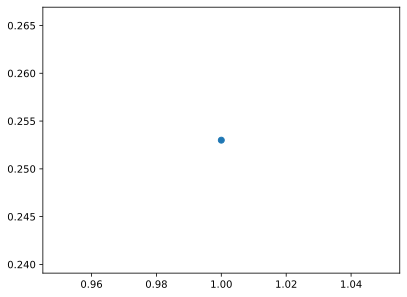

In [585]:

import matplotlib.pyplot as plt
# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------

loops = 1
shots_per_loop = 1000
all_samples = []
fidelities = []

coeffs = np.arange(0.5,1.5,0.1)

coeffs = [1]


for coeff in coeffs:
    # Noise channel
    noise_model = noise.GeminiOneZoneNoiseModel(scaling_factor=1.0)

    for i in range(loops):
        # Generate circuit
        cirq_enc = emit_circuit(a3_circuit)
        
        # Apply noise to this circuit
        noisy_cirq_enc = noise.transform_circuit(cirq_enc, model=noise_model)
        
        # Convert to stim circuit and sample
        squin_enc = load_circuit(noisy_cirq_enc)
        stim_enc = bloqade.stim.Circuit(squin_enc)
        sampler = stim_enc.compile_sampler()
        
        # Sample this noisy circuit
        samples = sampler.sample(shots=shots_per_loop)
        all_samples.extend(samples)

    samples_enc = np.array(all_samples)
    fidelities.append(find_good_rate(samples_enc,synd_dict))

print(fidelities)
np.save("try{i}".format(i=num_magic),np.asarray([dists[num_magic],fidelities[0]]))
plt.scatter(coeffs,fidelities)
plt.show()
    



In [586]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Model: y = A * p^(-n)
def scaling(p, A, n):
    return A * np.power(p, -n)

In [587]:
magics = []
fids = []
for num_magic in range(20):
    duble = np.load("try{i}.npy".format(i=num_magic))
    magics.append(duble[0])
    fids.append(duble[1])

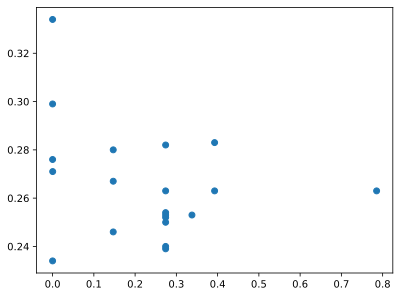

In [588]:
plt.scatter(magics,fids)
plt.show()

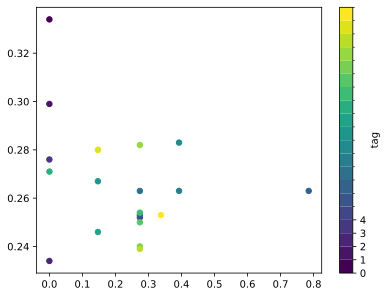

In [589]:
import matplotlib.colors as mcolors

# tags: array-like of ints in [0, 19]
# x, y: same length
tags = range(20)
cmap = plt.get_cmap("viridis", 20)                 # 20 discrete colors
norm = mcolors.BoundaryNorm(range(21), cmap.N)   # bins: [0,1), [1,2), ... [19,20)

plt.scatter(magics, fids, c=tags, cmap=cmap, norm=norm, s=30)

# Optional: colorbar with integer ticks 0..19
cbar = plt.colorbar(ticks=range(5))
cbar.set_label("tag")

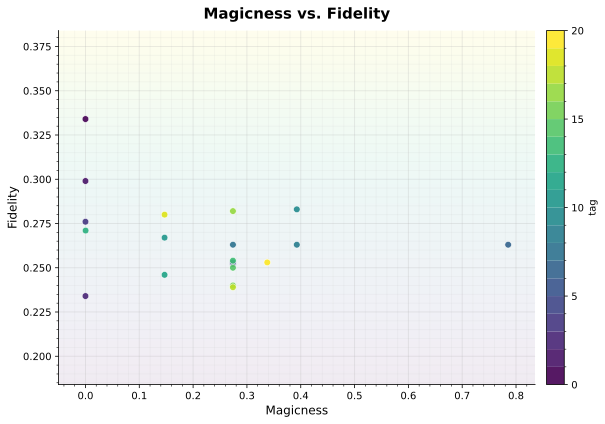

In [590]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_magicness_vs_fidelity(x, y, tags):
    x = np.asarray(x)
    y = np.asarray(y)
    tags = np.asarray(tags)

    # Discrete colormap for tags 0..19
    cmap = plt.get_cmap("viridis", 20)
    norm = mcolors.BoundaryNorm(np.arange(21), cmap.N)

    fig, ax = plt.subplots(figsize=(9, 6), dpi=140)

    # --- "Shading and stuff" (subtle background gradient) ---
    # A very light vertical gradient behind the plot area
    ymin, ymax = np.nanmin(y)-0.05, np.nanmax(y)+0.05
    xmin, xmax = np.nanmin(x)-0.05, np.nanmax(x)+0.05
    grad = np.linspace(0, 1, 256).reshape(-1, 1)
    ax.imshow(
        grad,
        extent=[xmin, xmax, ymin, ymax],
        origin="lower",
        aspect="auto",
        alpha=0.08,        # subtle
        zorder=0
    )

    # Scatter points
    sc = ax.scatter(
        x, y,
        c=tags,
        cmap=cmap,
        norm=norm,
        s=45,
        alpha=0.9,
        linewidths=0.6,
        edgecolors="white",
        zorder=2
    )

    # Titles / labels
    ax.set_title("Magicness vs. Fidelity", pad=12, fontsize=15, weight="bold")
    ax.set_xlabel("Magicness", fontsize=12)
    ax.set_ylabel("Fidelity", fontsize=12)

    # Grid + spines cleanup
    ax.grid(True, which="major", alpha=0.25, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.12, linewidth=0.8)
    ax.minorticks_on()
    ax.set_axisbelow(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Discrete colorbar with integer ticks
    cbar = fig.colorbar(sc, ax=ax, ticks=np.arange(0,21,5), pad=0.02)
    cbar.set_label("tag", rotation=90)

    plt.tight_layout()
    plt.show()

# usage:
plot_magicness_vs_fidelity(magics, fids, tags)
